In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

##################################
## Model Parameters
##################################

remove_label_outliers = False
impute_strategy = 'mean'
scaling_method = 'standard'
do_linear_models = True
do_ensemble_models = True
cross_validation_k_folds = 8

In [2]:
from azureml import Workspace
ws = Workspace(
    workspace_id='bbc0f7b3b64843179da5e569144550aa',
    authorization_token='iNjA9YbRxZiG/fAqpTWW6qprqTldqAkTGbvnuGX3yMjrgEzgpNHY4bkHhAZ/x7xvixWPG9i6SdC77Vk35+CFrw==',
    endpoint='https://europewest.studioapi.azureml.net'
)

%matplotlib inline
plt.style.use('ggplot')

ds = ws.datasets['train_values.csv']
X = ds.to_dataframe()

ds = ws.datasets['train_labels.csv']
Y = ds.to_dataframe()

ds = ws.datasets['test_values.csv']
X_score = ds.to_dataframe()

X = X.set_index('row_id')
Y = Y.set_index('row_id')
X_score = X_score.set_index('row_id')

In [3]:
##################################
## Remove features
##################################
def removeFeatures(x):
    return x

X = removeFeatures(X)
X_score = removeFeatures(X_score)

##################################
## Fixing categorical data
##################################

print ('\nTraining dataset shape:\n%d rows, %d features' %(X.shape[0], X.shape[1]))

def OneHotEncode(x):
    categorical = x.select_dtypes(exclude=[np.number])
    return pd.get_dummies(x, columns=categorical.columns)

def makeCategorical(x, feature, value_list):
    x[feature] = x[feature].astype("category", categories = value_list)
    return x

def fixCategoricalData(df):
    df = makeCategorical(df, 'school__degrees_awarded_highest', ["Non-degree-granting", "Certificate degree", "Associate degree", "Bachelor's degree", "Graduate degree"])
    df = makeCategorical(df, 'school__degrees_awarded_predominant', ["Not classified", "Predominantly certificate-degree granting", "Predominantly associate's-degree granting", "Predominantly bachelor's-degree granting", "Entirely graduate-degree granting"])
    df = makeCategorical(df, 'school__institutional_characteristics_level', ["2-year", "4-year", "Less-than-2-year"])
    df = makeCategorical(df, 'school__ownership', ["Public", "Private for-profit", "Private nonprofit"])
    df = makeCategorical(df, 'school__region_id', ["Plains (IA, KS, MN, MO, NE, ND, SD)", "New England (CT, ME, MA, NH, RI, VT)", "Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC, TN, VA, WV)", "Mid East (DE, DC, MD, NJ, NY, PA)", "Great Lakes (IL, IN, MI, OH, WI)", "Far West (AK, CA, HI, NV, OR, WA)", "Southwest (AZ, NM, OK, TX)", "Rocky Mountains (CO, ID, MT, UT, WY)", "Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)"])
    df = makeCategorical(df, 'school__state', ["axc", "fga", "oly", "dmg", "hbt", "jgn", "kll", "xve", "dfy", "oon", "oli", "iqy", "qim", "shi", "ccg", "dkf", "ipu", "tbs", "luw", "pxv", "hww", "lff", "slp", "wjh", "idw", "ezv", "vvi", "zdl", "jsu", "hks", "bww", "fxt", "rxy", "cfi", "rse", "kus", "oub", "uah", "rya", "eyi", "wto", "gkt", "bkc", "znt", "slo", "hqy", "rgs", "cmz", "kdg", "pdh", "ahh", "twr", "xws", "por", "uuo", "nhl", "hmr", "jfm"])
    df = makeCategorical(df, 'school__main_campus', ["Main campus", "Not main campus"])
    df = makeCategorical(df, 'school__online_only', ["Not distance-education only", "nan", "Distance-education only"])
    return df

X = fixCategoricalData(X)
X_score = fixCategoricalData(X_score)

X = OneHotEncode(X)
X_score = OneHotEncode(X_score)

print ('Fixed categories!\nNew number of features %d ' % X.shape[1])


Training dataset shape:
17107 rows, 297 features
Fixed categories!
New number of features 380 


In [4]:
##################################
## Handling Outliers
##################################
def DetectOutliers(x):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 2)
    upper_bound = q3 + (iqr * 2)
    indices = x[(x > upper_bound) | (x < lower_bound)].index
    return indices

def RemoveOutliers(x, indexes):
    return x.drop(indexes, axis=0)

if (remove_label_outliers):
    outliers = DetectOutliers(Y['income'])
    print ('\nFound %d outliers for income:\n' % len(outliers))
    print ('Original statistics\n', Y['income'].describe())
    X = RemoveOutliers(X, outliers)
    Y = RemoveOutliers(Y, outliers)

    print ('\nRemoving values:\nNew observation count: ', X.shape[0])
    print ('Original statistics\n', Y['income'].describe())

In [5]:
##################################
## Filling missing values
##################################
from sklearn.preprocessing import Imputer

def percentage(numerator, denomenator):
    if type(numerator) == pd.core.series.Series:
        return (numerator/denomenator*100).map('{:.1f}%'.format)
    
    elif type(numerator) == int or type(numerator) == float:
        return '{:.1f}%'.format(float(numerator)/float(denomenator)*100)
    
    else:
        print("check type")

def DisplayFeatureCompleteness(df):
    nums = df.count()
    nums = nums[nums < df.shape[0]].sort_values(ascending=True)
    print ("Found %d features with missing value:\n" % nums.shape[0])
    if (nums.shape[0] > 0):
        print (percentage(nums, df.shape[0]).head(5))
        print ('...')
        print (percentage(nums, df.shape[0]).tail(5))

print ('\nFixing missing values:')
DisplayFeatureCompleteness(X)

columns = X.columns
imputer = Imputer(strategy=impute_strategy)
imputer.fit(X)
X = imputer.transform(X)
X_score = imputer.transform(X_score)

#rearrange DataFrame after transform
X = pd.DataFrame(X, columns=columns)
X_score = pd.DataFrame(X_score, columns=columns)

print ('\nAfter imputing using ''%s'':' % impute_strategy)
DisplayFeatureCompleteness(X)



Fixing missing values:
Found 287 features with missing value:

student__share_firstgeneration_parents_middleschool     0.5%
admissions__act_scores_75th_percentile_writing          2.5%
admissions__act_scores_midpoint_writing                 2.5%
admissions__act_scores_25th_percentile_writing          2.5%
admissions__sat_scores_75th_percentile_writing         11.6%
dtype: object
...
student__demographics_first_generation    96.0%
student__share_firstgeneration            96.0%
student__demographics_dependent           97.9%
student__share_independent_students       97.9%
student__demographics_age_entry           99.7%
dtype: object

After imputing using mean:
Found 0 features with missing value:



In [6]:
##################################
## Scaling Features
##################################
from sklearn import preprocessing

def StandardScaler(x):
    # create scaler
    scaler = preprocessing.StandardScaler()
    #scale feature
    x_scale = scaler.fit_transform(x)
    return x_scale, scaler

def RobustScaler(x):
    # create scaler
    scaler = preprocessing.RobustScaler()
    #scale feature
    x_scale = scaler.fit_transform(x)
    return x_scale, scaler

print ('\nScaling features using %s:' % scaling_method)
print ('Sample feature before\n', X['school__faculty_salary'].describe())

if (scaling_method == 'standard'):
    X, scaler = StandardScaler(X)
else:
    X, scaler = RobustScaler(X)

X_score = scaler.transform(X_score)

#rearrange DataFrame after transform
X = pd.DataFrame(X, columns=columns)
X_score = pd.DataFrame(X_score, columns=columns)

print ('\nSample feature after\n', X['school__faculty_salary'].describe())


Scaling features using standard:
Sample feature before
 count    17107.000000
mean      5797.635609
std       1668.135090
min        153.000000
25%       5051.500000
50%       5797.635609
75%       6163.000000
max      24892.000000
Name: school__faculty_salary, dtype: float64

Sample feature after
 count    1.710700e+04
mean    -2.474189e-16
std      1.000029e+00
min     -3.383899e+00
25%     -4.473004e-01
50%     -5.452324e-16
75%      2.190321e-01
max      1.144687e+01
Name: school__faculty_salary, dtype: float64


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.model_selection import cross_val_score

y = Y['income']

param_grid = {"n_estimators":[500],
              "max_features": np.linspace(0.5,1.0,4)
             }
extraEstimator = ExtraTreesRegressor()


grid = GridSearchCV(extraEstimator, param_grid,n_jobs=-1, cv=8, scoring='neg_mean_squared_error', verbose=4)
grid.fit(X, y)

print('Using ExtraTrees:')
print('Best Score:', grid.best_score_) 
print('Best Params:', grid.best_params_) 

y_pred = grid.predict(X)
print("Root of Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

test_results = grid.predict(X_score)

T = pd.DataFrame(test_results)
T.columns = ['income']
T.to_csv('results.csv')



Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 53.3min finished


Using ExtraTrees:
Best Score: -12.7395213783
Best Params: {'max_features': 0.5, 'n_estimators': 500}
Root of Mean squared error: 0.07
Variance score: 1.00


### BEST SO FAR

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)
          
Using ExtraTrees:
Best Score: -12.7064558884
Best Params: {'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Root of Mean squared error: 0.07
Variance score: 1.00

### Next Step: do Feature reduction and test with current parameters and Hypertuning

In [8]:
from sklearn.ensemble import ExtraTreesRegressor
bestmodel = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1, oob_score=False, random_state=None, verbose=0, warm_start=False)

y = Y['income']

from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=bestmodel, step=10, n_jobs=-1, verbose=4, cv=8,
              scoring='neg_mean_squared_error')
rfecv.fit(X, y)


RFECV(cv=8,
   estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=-1, scoring='neg_mean_squared_error', step=10, verbose=4)

Optimal number of features : 290


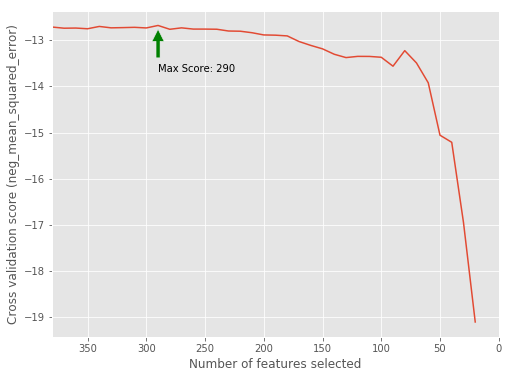

In [12]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (neg_mean_squared_error)")
ax.set_xlim(380,0)
x = range(20,385,10)

ax.plot(x, rfecv.grid_scores_[2:])

xmax = rfecv.n_features_
ymax = max(rfecv.grid_scores_)
ax.annotate('Max Score: %d' %rfecv.n_features_, xy=(xmax, ymax), xytext=(xmax, ymax-1),
            arrowprops=dict(facecolor='green', shrink=0.1),
            )
plt.show()


In [13]:
F = pd.DataFrame()
F['features'] = X.columns
F['ranking'] = rfecv.ranking_
F['important'] = rfecv.get_support()

# save features for later if we want to reuse it without running RFECV
F[F['important'] == True].to_csv('important_features.csv')

test_results = rfecv.predict(X_score)
print("Root of Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

T = pd.DataFrame(test_results)
T.columns = ['income']
T.to_csv('results_with_RFECV_before_hyper.csv')

# Put the best features into new df X_new
X_new = rfecv.transform(X)
X_score_new = rfecv.transform(X_score)

In [14]:
# rerun estimator on top of X_new
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.model_selection import cross_val_score

param_grid = {"n_estimators":[500],
              "max_features": np.linspace(0.5,1.0,4)
             }

extraEstimator = ExtraTreesRegressor()

grid = GridSearchCV(extraEstimator, param_grid,n_jobs=-1, cv=8, scoring='neg_mean_squared_error', verbose=4)
grid.fit(X_new, y)

print('Using ExtraTrees After Feature Reduction:')
print('Best Score:', grid.best_score_) 
print('Best Params:', grid.best_params_) 

y_pred = grid.predict(X_new)
print("Root of Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

test_results = grid.predict(X_score_new)

T = pd.DataFrame(test_results)
T.columns = ['income']
T.to_csv('results_with_RFECV_after_hyper.csv')

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 45.4min finished


Using ExtraTrees After Feature Reduction:
Best Score: -12.6799093755
Best Params: {'max_features': 0.5, 'n_estimators': 500}
Root of Mean squared error: 0.07
Variance score: 1.00
